In [9]:
%load_ext autoreload
%autoreload 2
%pylab inline

from matplotlib.colors import ListedColormap
import pandas as pd
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.base import clone
from sklearn.datasets import make_circles
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix, DecisionBoundariesVisualizer

from BEKML import BEMKL

from utils import  (evaluate_model, poly_kernel, gauss_kernel, scoring,
                    DATA_CMAP, DATA_COLORS, DATA_MARKERS, plot_e_a_mu)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)
N = 1000
D = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [2]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(39, 39)

# Clean Data

In [3]:
X, y = make_circles(N, factor=0.1, noise=0.01)
data = pd.DataFrame(X, columns=['x1', 'x2'])
y[y == 0] = -1
data['y'] = y

display(data.head())
data.describe()

,x1,x2,y
0,-0.005364,0.993310,-1
1,0.106454,0.004204,1
2,-0.029099,0.108372,1
3,0.105535,-0.039679,1
4,0.960845,-0.190159,-1


,x1,x2,y
count,1000.000000,1000.000000,1000.0000
mean,-0.000112,0.000397,0.0000
std,0.502425,0.502899,1.0005
min,-1.012679,-1.019605,-1.0000
25%,-0.105818,-0.103642,-1.0000
50%,0.000513,0.001991,0.0000
75%,0.104884,0.104510,1.0000
max,1.009513,1.012313,1.0000


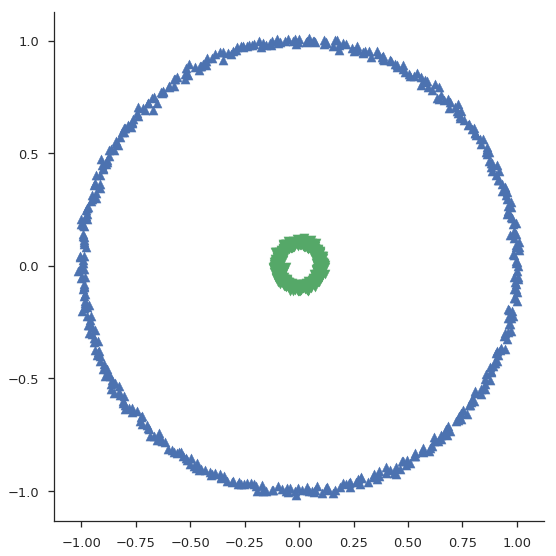

In [4]:
ax = plt.figure(figsize=(8, 8)).gca()
ax.scatter(data.x1[data.y==-1], data.x2[data.y==-1],
           c=DATA_COLORS[0], marker=DATA_MARKERS[0])
ax.scatter(data.x1[data.y==1], data.x2[data.y==1],
           c=DATA_COLORS[1], marker=DATA_MARKERS[1])
sns.despine()
plt.tight_layout()

## Sparse Model

0 - Kernels: 3/39 (0.07692307692307693). SV: 661/666 (0.9924924924924925). Mean e: 0.0639. Median e: -0.0000. Std e: 0.2215. 
1 - Kernels: 3/39 (0.07692307692307693). SV: 664/666 (0.996996996996997). Mean e: 0.0653. Median e: -0.0000. Std e: 0.2261. 
2 - Kernels: 3/39 (0.07692307692307693). SV: 664/668 (0.9940119760479041). Mean e: 0.0640. Median e: -0.0000. Std e: 0.2217. 
3 - Kernels: 3/39 (0.07692307692307693). SV: 660/666 (0.990990990990991). Mean e: 0.0654. Median e: -0.0000. Std e: 0.2264. 
4 - Kernels: 3/39 (0.07692307692307693). SV: 658/666 (0.987987987987988). Mean e: 0.0642. Median e: -0.0000. Std e: 0.2222. 
5 - Kernels: 3/39 (0.07692307692307693). SV: 660/668 (0.9880239520958084). Mean e: 0.0656. Median e: -0.0000. Std e: 0.2274. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 15.8767,  14.979 ,  16.0124,  14.9469,  15.7588,  13.4959]),
 'score_time': array([ 1.5776,  1.5592,  1.416 ,  1.5675,  1.415 ,  1.5749]),
 'test_score': array([ 1.,  1.,  1.,  1.,  1.,  1.]),
 'train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.])}

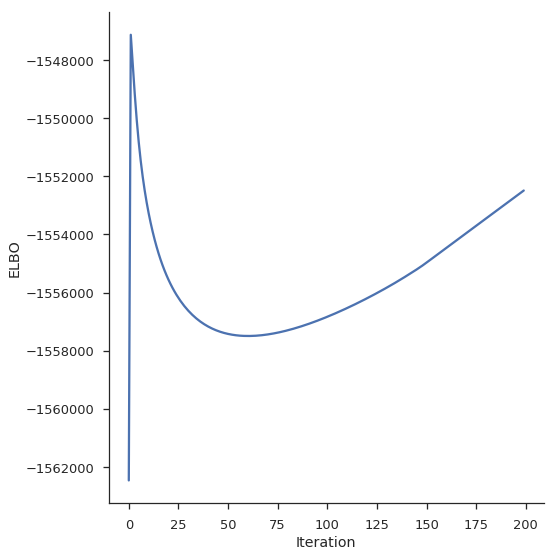

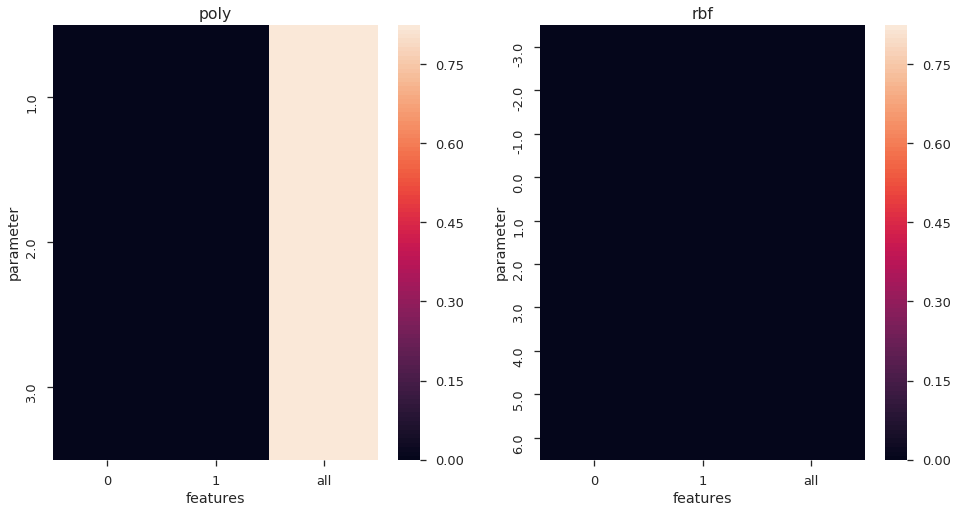

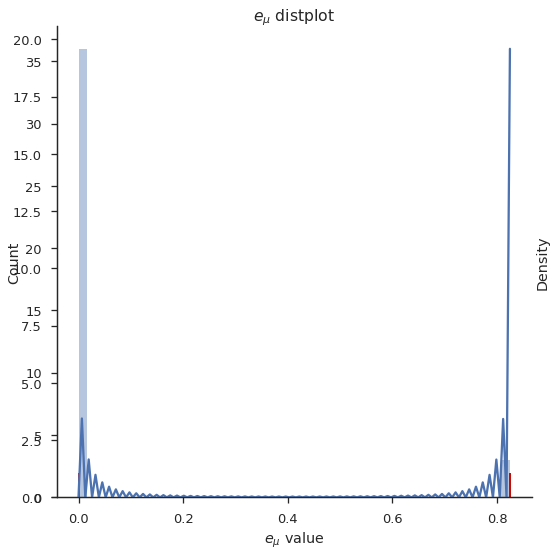

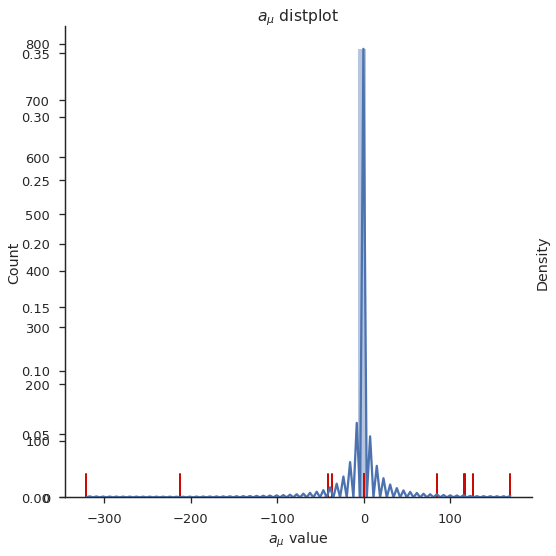

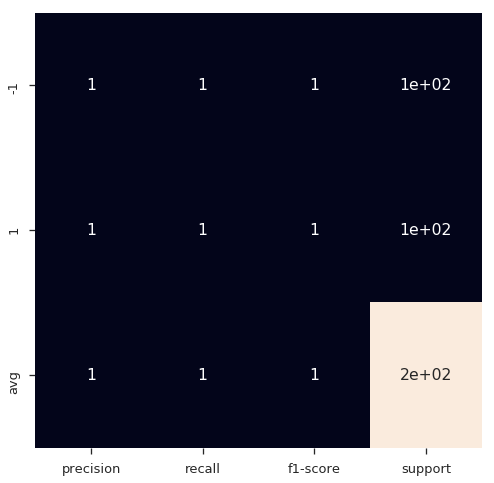

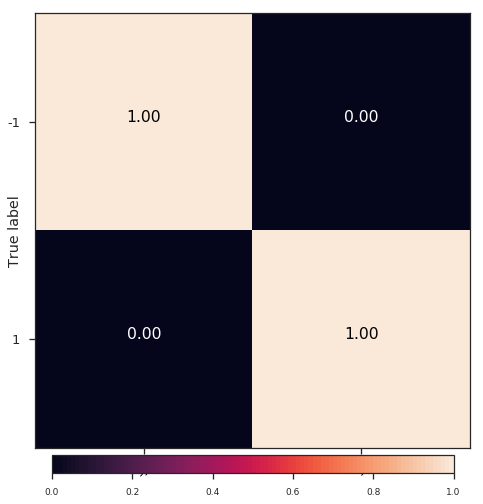

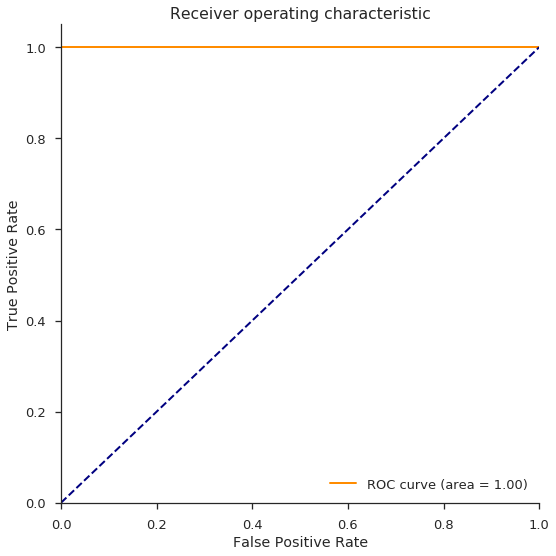

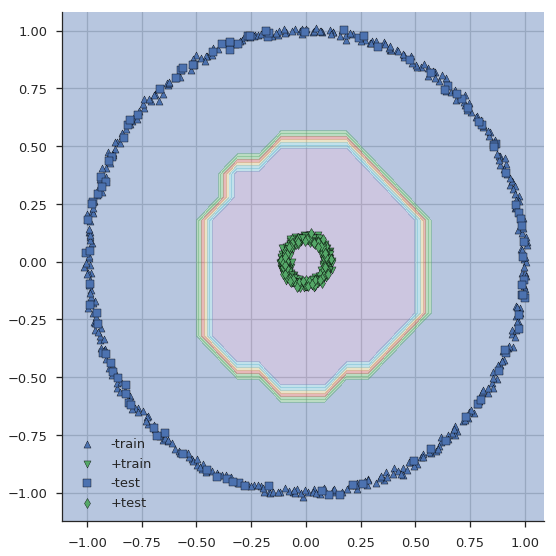

In [6]:
cc_sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                        beta_gamma=1, alpha_omega=1e-11, beta_omega=1e+9,
                        e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                        filter_kernels=False, filter_sv=False,
                        verbose=False)
evaluate_model(cc_sparse_model, X, y, kernel_attrs)

## Dense Model

[autoreload of utils failed: Traceback (most recent call last):
  File "/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/mtambos/anaconda/envs/pml/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/mtambos/anaconda/envs/pml/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
 

0 - Kernels: 39/39 (1.0). SV: 664/666 (0.996996996996997). Mean e: 0.0684. Median e: -0.0024. Std e: 0.2059. 
1 - Kernels: 39/39 (1.0). SV: 661/666 (0.9924924924924925). Mean e: 0.0683. Median e: -0.0032. Std e: 0.2025. 
2 - Kernels: 29/39 (0.7435897435897436). SV: 663/668 (0.9925149700598802). Mean e: 0.0683. Median e: -0.0031. Std e: 0.2069. 
3 - Kernels: 39/39 (1.0). SV: 659/666 (0.9894894894894894). Mean e: 0.0691. Median e: -0.0022. Std e: 0.2027. 
4 - Kernels: 39/39 (1.0). SV: 656/666 (0.984984984984985). Mean e: 0.0693. Median e: -0.0025. Std e: 0.2017. 
5 - Kernels: 39/39 (1.0). SV: 663/668 (0.9925149700598802). Mean e: 0.0699. Median e: -0.0030. Std e: 0.2049. 


/home/mtambos/anaconda/envs/pml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 15.5019,  13.1148,  12.508 ,  13.4727,  12.8203,  13.9946]),
 'score_time': array([ 1.4019,  1.4298,  1.366 ,  1.3555,  1.3627,  1.433 ]),
 'test_score': array([ 1.,  1.,  1.,  1.,  1.,  1.]),
 'train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.])}

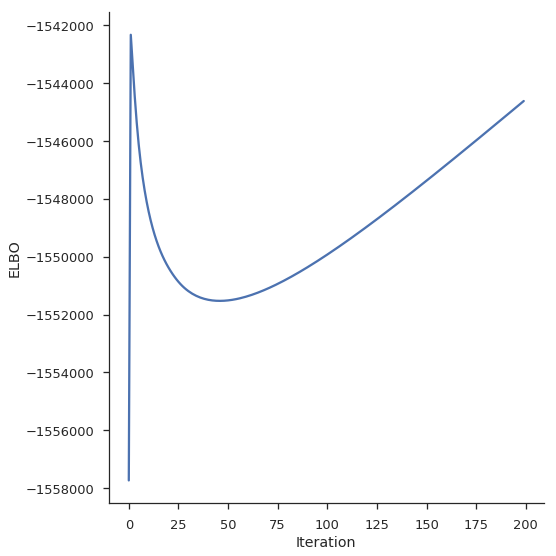

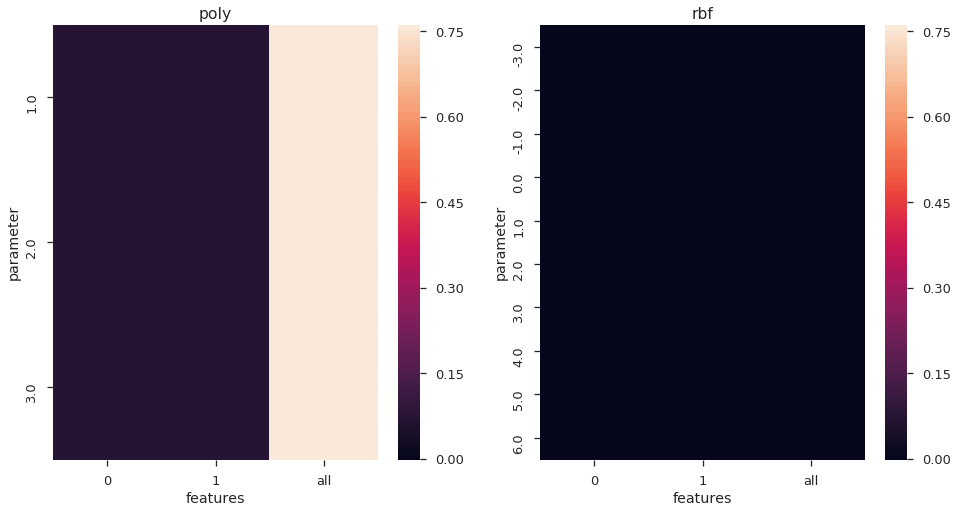

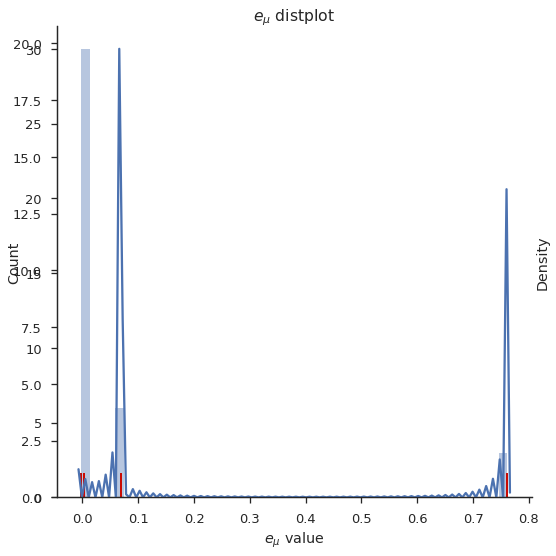

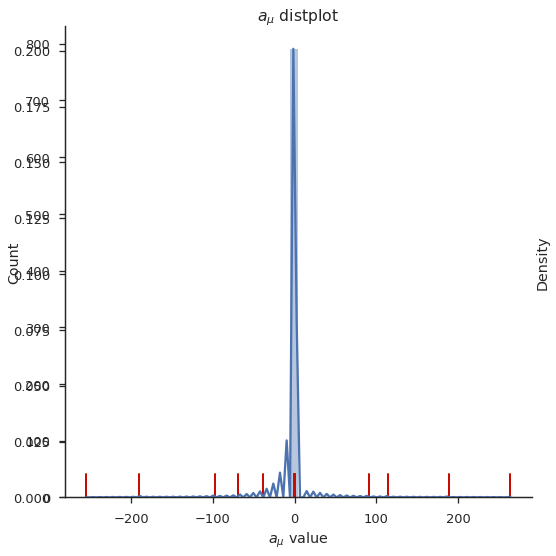

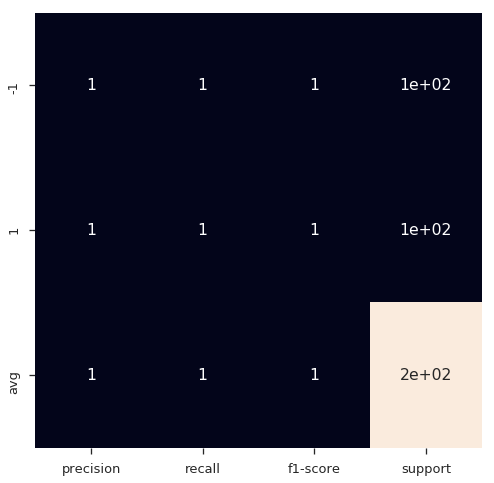

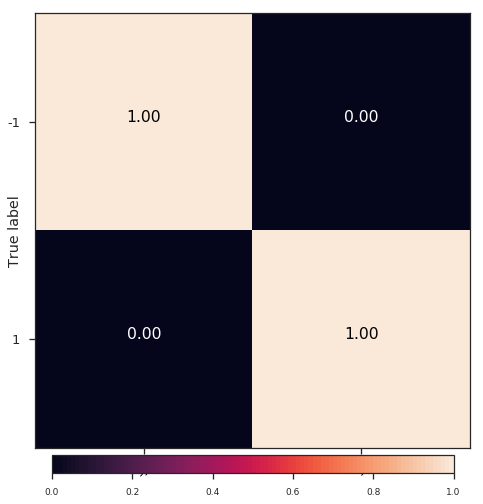

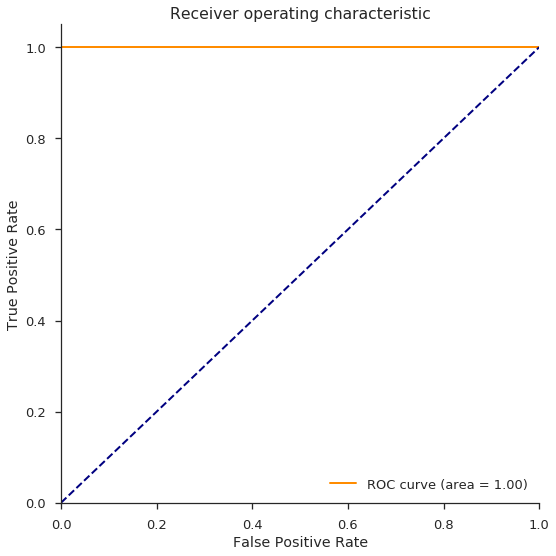

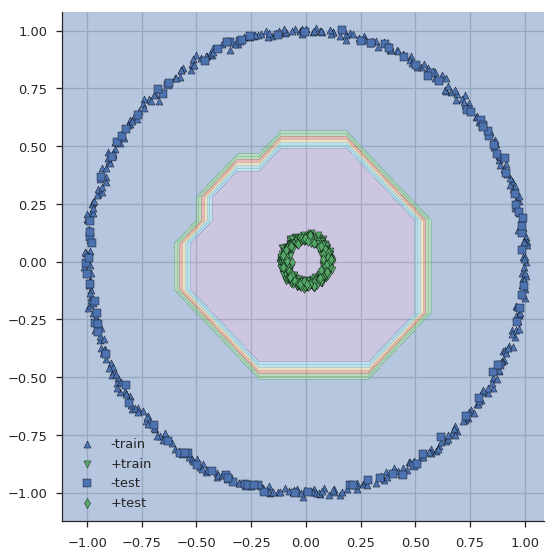

In [7]:
cc_normal_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                        beta_gamma=1, alpha_omega=1, beta_omega=1,
                        e_null_thrsh=1e-3, a_null_thrsh=1e-3,
                        filter_kernels=False, filter_sv=False,
                        verbose=False)
evaluate_model(cc_normal_model, X, y, kernel_attrs)

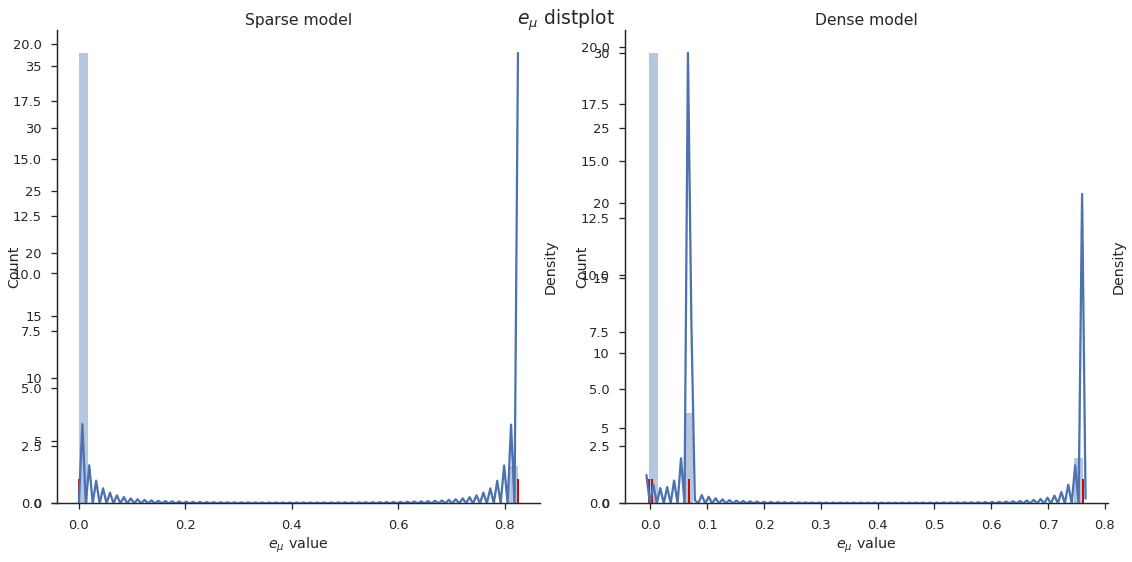

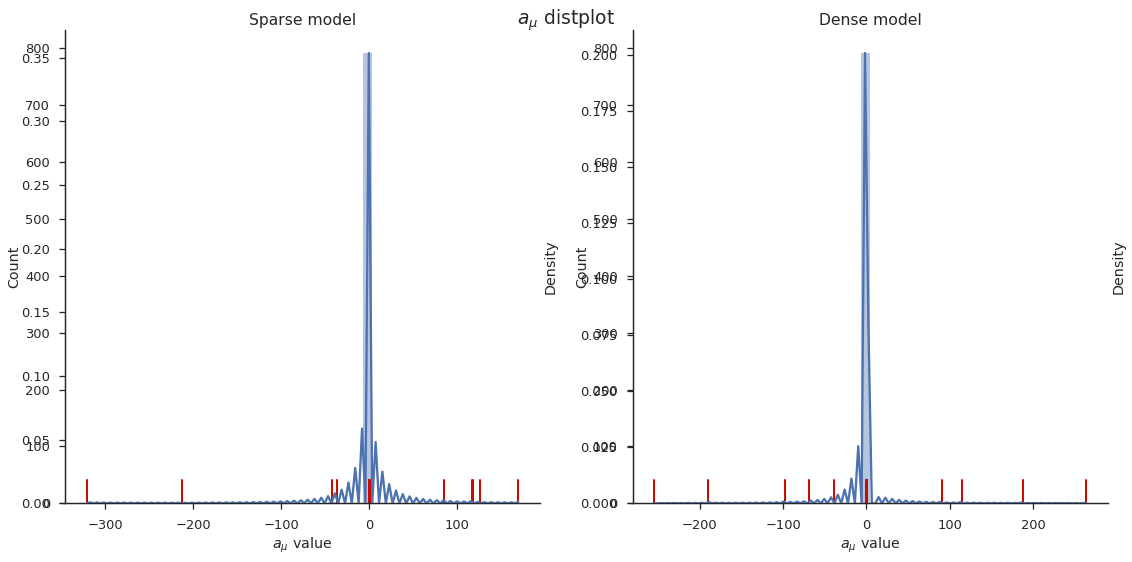

In [10]:
plot_e_a_mu(cc_sparse_model, cc_normal_model,
            'Sparse model', 'Dense model')